In [2]:
import tensorflow as tf
import numpy as np
from censai.models import Autoencoder
from censai.cosmos_utils import decode, preprocess
from censai.utils import nullwriter
import os
from datetime import datetime
from argparse import ArgumentParser
from censai.galflow import convolve
from scipy.signal import tukey
from numpy import pi
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import time
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)


class PolynomialSchedule:
    def __init__(self, initial_value, end_value, power, decay_steps):
        self.initial_value = initial_value
        self.end_value = end_value
        self.power = power
        self.decay_steps = decay_steps

    def __call__(self, step=None):
        if step is None:
            step = tf.summary.experimental.get_step()
        step = min(step, self.decay_steps)
        return ((self.initial_value - self.end_value) * (1 - step / self.decay_steps) ** (self.power)) + self.end_value


def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    '''
    return [atoi(c) for c in re.split(r'(\d+)', text)]


1 Physical GPUs, 1 Logical GPUs


In [18]:
import sys
sys.argv = ['']
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
parser = ArgumentParser()
parser.add_argument("--model_id", type=str, default="None",
                    help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--pixels", default=128, type=int, help="Number of pixels on a side, should be fixed for a given cosmos tfrecord")
parser.add_argument("--num_parallel_reads", default=1, type=int, help="TF dataset number of parallel processes loading the data while training")
parser.add_argument("--data", default="../data/cosmos_25.2", help="Path to the data root directory, containing tf records files")

# training params
parser.add_argument("--split", default=0.8, type=float, help="Training split, number in the range [0.5, 1)")
parser.add_argument("--test_shards", default=70, type=int, help="Number of shards to keep as a test set. The largest shard index are kept")
parser.add_argument("--examples_per_shard", default=1000, type=int,
                    help="Number of example on a given COSMO shard. Should match the parameter of cosmo_to_tfrecords with which it was generated")
parser.add_argument("-b", "--batch_size", default=100, type=int, required=False, help="Number of images in a batch")
parser.add_argument("-e", "--epochs", default=1, type=int, help="Number of epochs for training")
parser.add_argument("--patience", default=np.inf, type=float, help="Number of epoch at which "
                                                            "training is stop if no improvement have been made")
parser.add_argument("--tolerance", default=0, type=float,
                    help="Percentage [0-1] of improvement required for patience to reset. The most lenient "
                                                    "value is 0 (any improvement reset patience)")
parser.add_argument("--learning_rate", default=1e-4, type=float,
                    help="Initial value of the learning rate")
parser.add_argument("--decay_rate", type=float, default=1,
                    help="Decay rate of the exponential decay schedule of the learning rate. 1=no decay")
parser.add_argument("--decay_steps", type=int, default=100)
parser.add_argument("--staircase", action="store_true", help="Learning schedule is a staircase "
                                                             "function if added to arguments")
parser.add_argument("--apodization_alpha", default=1, type=float,
                    help="Shape parameter of the Tukey window (Tapered cosine Window),"\
                    "representing the fraction of the window inside the cosine tapered region."\
                    "If zero, the Tukey window is equivalent to a rectangular window (no apodization)"\
                    "If one, the Tukey window is equivalent to a Hann window.")
parser.add_argument("--apodization_factor", default=1, type=float,
                    help="Lagrange multiplier of apodization loss")
parser.add_argument("--tv_factor", default=1, type=float,
                    help="Lagrange multiplier of Total Variation (TV) loss. Penalize high spatial frequency"
                         "components in the predicted image")
parser.add_argument("--l2_bottleneck", default=1, type=float,
                    help="Initial value of l2 penalty in bottleneck identity "
                         "map of encoder/decoder latent representation")
parser.add_argument("--l2_bottleneck_decay_steps", default=1000, type=int,
                    help="Number of steps until l2 bottleneck penalty factor reaches 0")
parser.add_argument("--l2_bottleneck_decay_power", default=0.2, type=float,
                    help="Control the shape of the decay of l2_bottlenck schedule (0.5=square root decay, etc.)")
parser.add_argument("--skip_strength", default=1, type=float,
                    help="Initial value of the multiplicative factor in front of the Unet additive skip between "
                         "encoder and decoder layers.")
parser.add_argument("--skip_strength_decay_steps", default=1000, type=int,
                    help="Number of steps until skip_strength reaches 0")
parser.add_argument("--skip_strength_decay_power", default=0.5, type=float,
                    help="Control the shape of the decay for skip_strength schedule")


# model hyperparameters
parser.add_argument("--res_layers", default=7, type=int,
                    help="Number of downsampling block in encoder (symmetric in decoder")
parser.add_argument("--conv_layers_in_res_block", default=2, type=int,
                    help="Number of conv layers in a Residual block")
parser.add_argument("--filter_scaling", default=2, type=float,
                    help="Filters scale by {filter_scaling}^{res_layer_index}, generally number between (1, 2]")
parser.add_argument("--filter_init", default=8, type=int,
                    help="Number of filters in the first residual block (before last for decoder)")
parser.add_argument("--kernel_size", default=3, type=int,
                    help="Size of the kernels throughout model")
parser.add_argument("--kernel_reg_amp", default=1e-2, type=float,
                    help="Amplitude of l2 regularization for kernel weights in the model")
parser.add_argument("--bias_reg_amp", default=1e-2, type=float,
                    help="Amplitude of l2 regularization for bias variables in the model")
parser.add_argument("--relu_alpha", default=0.1, type=float,
                    help="Slope of LeakyReLu in the negative plane")
parser.add_argument("--resblock_dropout_rate", default=None, type=float,
                    help="Number between [0, 1), number of filters to drop at each call. Default is to not use dropout")
parser.add_argument("--latent_size", default=16, type=int,
                    help="Size of the latent vector space")
parser.add_argument("--res_architecture", default="bare", type=str, 
                    help="Name of the Resnet Block architecture. Options are "\
                         "'bare', 'original', 'bn_after_addition', "\
                         "'relu_before_addition', 'relu_only_pre_activation', "\
                         "'full_pre_activation', 'full_pre_activation_rescale'")

# logs
parser.add_argument("--logdir", default="None",
                    help="Path of logs directory. Default if None, no logs recorded")
parser.add_argument("--model_dir", default="None",
                    help="Path to the directory where to save models checkpoints")
parser.add_argument("--checkpoints", default=10, type=int,
                    help="Save a checkpoint of the models each {%} iteration")
parser.add_argument("--max_to_keep", default=3, type=int,
                    help="Max model checkpoint to keep")
parser.add_argument("--logname", default="cosmosAE_" + date,
                    help="Name of the logs, default is the local date + time")

args = parser.parse_args()

In [23]:
cache_file = os.path.join(os.getenv("SLURM_TMPDIR"), "cache") # temporary location of dataset

filenames = os.listdir(args.data)
filenames.sort(key=natural_keys)
# keep the n last files as a test set
if args.test_shards != 0:
    filenames = filenames[:-args.test_shards]
filenames = [os.path.join(args.data, file) for file in filenames]
train_size = len(filenames) * args.examples_per_shard  # estimate the length of the dataset
dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=args.num_parallel_reads)
dataset = dataset.map(decode)
dataset = dataset.map(preprocess)
dataset = dataset.shuffle(buffer_size=args.examples_per_shard)  # shuffle images inside a shard
train_dataset = dataset.take(int(train_size * args.split))
test_dataset = dataset.skip(int(train_size * (1 - args.split)))
train_dataset = train_dataset.batch(args.batch_size, drop_remainder=False)
test_dataset = test_dataset.batch(args.batch_size, drop_remainder=True)
train_dataset = train_dataset.enumerate()
train_dataset = train_dataset.cache(cache_file)
test_dataset = test_dataset.cache(cache_file)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.decay_rate,
    decay_steps=args.decay_steps,
    staircase=args.staircase
)
skip_strength_schedule = PolynomialSchedule(
    initial_value=args.skip_strength,
    end_value=0.,
    power=args.skip_strength_decay_power,
    decay_steps=args.skip_strength_decay_steps
)
l2_bottleneck_schedule = PolynomialSchedule(
    initial_value=args.l2_bottleneck,
    end_value=0.,
    power=args.l2_bottleneck_decay_power,
    decay_steps=args.l2_bottleneck_decay_steps
)

optim = tf.optimizers.Adam(learning_rate=learning_rate_schedule)
AE = Autoencoder(
    pixels=args.pixels,
    res_layers=args.res_layers,
    conv_layers_in_resblock=args.conv_layers_in_res_block,
    filter_scaling=args.filter_scaling,
    filter_init=args.filter_init,
    kernel_size=args.kernel_size,
    res_architecture=args.res_architecture,
    kernel_reg_amp=args.kernel_reg_amp,
    bias_reg_amp=args.bias_reg_amp,
    alpha=args.relu_alpha,
    resblock_dropout_rate=args.resblock_dropout_rate,
    latent_size=args.latent_size
)

# setup tensorboard writer (nullwriter in case we do not want to sync)
if args.model_id.lower() != "none":
    logname = args.model_id
else:
    logname = args.logname
if args.logdir.lower() != "none":
    logdir = os.path.join(args.logdir, logname)
    traindir = os.path.join(logdir, "train")
    testdir = os.path.join(logdir, "test")
    if not os.path.isdir(logdir):
        os.mkdir(logdir)
    if not os.path.isdir(traindir):
        os.mkdir(traindir)
    if not os.path.isdir(testdir):
        os.mkdir(testdir)
    train_writer = tf.summary.create_file_writer(traindir)
    test_writer = tf.summary.create_file_writer(testdir)
else:
    test_writer = nullwriter()
    train_writer = nullwriter()
if args.model_dir.lower() != "none":
    models_dir = os.path.join(args.model_dir, logname)
    if not os.path.isdir(models_dir):
        os.mkdir(models_dir)
    encoder_checkpoints_dir = os.path.join(models_dir, "encoder_checkpoints")
    if not os.path.isdir(encoder_checkpoints_dir):
        os.mkdir(encoder_checkpoints_dir)
    decoder_checkpoints_dir = os.path.join(models_dir, "decoder_checkpoints")
    if not os.path.isdir(decoder_checkpoints_dir):
        os.mkdir(decoder_checkpoints_dir)
    encoder_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=AE.encoder)
    encoder_checkpoint_manager = tf.train.CheckpointManager(encoder_ckpt, encoder_checkpoints_dir, max_to_keep=3)
    decoder_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=AE.decoder)
    decoder_checkpoint_manager = tf.train.CheckpointManager(decoder_ckpt, decoder_checkpoints_dir, max_to_keep=3)
    save_checkpoint = True
    if args.model_id.lower() != "none":
        encoder_checkpoint_manager.checkpoint.restore(encoder_checkpoint_manager.latest_checkpoint)
        decoder_checkpoint_manager.checkpoint.restore(decoder_checkpoint_manager.latest_checkpoint)
else:
    save_checkpoint = False

epoch_loss = tf.metrics.Mean()
test_loss = tf.metrics.Mean()
best_loss = np.inf
patience = args.patience
step = 0
end = 0
time_per_step = tf.metrics.Mean()

In [24]:
for epoch in tqdm(range(args.epochs)):
    epoch_loss.reset_states()
    test_loss.reset_states()
    with train_writer.as_default():
        for batch, (X, PSF, PS) in train_dataset:
            if step != 0:
                time_per_step.update_state([time.time() - start])
            start = time.time()
            sys.stdout.write("Step: %d, Time %.4f   \r" % (step, time_per_step.result()) )
            sys.stdout.flush()
            with tf.GradientTape() as tape:
                tape.watch(AE.trainable_variables)
                cost = tf.reduce_mean(AE.training_cost_function(
                    x=X,
                    psf=PSF,
                    ps=PS,
                    skip_strength=skip_strength_schedule(step),
                    l2_bottleneck=l2_bottleneck_schedule(step),
                    apodization_alpha=args.apodization_alpha,
                    apodization_factor=args.apodization_factor,
                    tv_factor=args.tv_factor
                ))
                cost += tf.reduce_sum(AE.losses)  # Add layer specific regularizer losses (L2 in definitions)
            gradient = tape.gradient(cost, AE.trainable_variables)
            # clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
            optim.apply_gradients(zip(gradient, AE.trainable_variables)) # backprop

            #========== Summary and logs ==========
            epoch_loss.update_state([cost])
            tf.summary.scalar("MSE", cost, step=step)
            step += 1
        tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
    with test_writer.as_default():
        for X, PSF, PS in test_dataset:
            time_per_step.update_state([time.time() - start])
            start = time.time()
            sys.stdout.write("Test, Time %.4f   \r" % (time_per_step.result()) )
            sys.stdout.flush()
            test_cost = tf.reduce_mean(AE.training_cost_function(
                x=X,
                psf=PSF,
                ps=PS,
                skip_strength=skip_strength_schedule(step),
                l2_bottleneck=l2_bottleneck_schedule(step),
                apodization_alpha=args.apodization_alpha,
                apodization_factor=args.apodization_factor,
                tv_factor=args.tv_factor
            ))
            test_loss.update_state([test_cost])
    tf.summary.scalar("MSE", test_loss.result(), step=step)
    print(f"epoch {epoch} | train loss {epoch_loss.result().numpy():.3e} | val loss {test_loss.result().numpy():.3e} "
          f"| learning rate {optim.lr(step).numpy():.2e}")
    if epoch_loss.result() < (1 - args.tolerance) * best_loss:
        best_loss = epoch_loss.result()
        patience = args.patience
    else:
        patience -= 1
    if save_checkpoint:
        encoder_checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
        decoder_checkpoint_manager.checkpoint.step.assign_add(1)
        if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1:
            encoder_checkpoint_manager.save()
            decoder_checkpoint_manager.save()
            print("Saved checkpoint for step {}: {}".format(int(encoder_checkpoint_manager.checkpoint.step),
                                                            encoder_checkpoint_manager.latest_checkpoint))
    if patience == 0:
        print("Reached patience")
        break

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [87]:
l2_bottleneck_schedule(step)

96.57302989075099

In [66]:
tf.reduce_mean(AE.training_cost_function(
                    x=X,
                    psf=PSF,
                    ps=PS,
                    skip_strength=skip_strength_schedule(step),
                    l2_bottleneck=l2_bottleneck_schedule(step),
                    apodization_alpha=args.apodization_alpha,
                    apodization_factor=args.apodization_factor,
                    tv_factor=args.tv_factor
                ))


<tf.Tensor: shape=(), dtype=float32, numpy=9004.25>

In [24]:
x=X
psf=PSF
ps=PS
skip_strength=skip_strength_schedule(step)
l2_bottleneck=l2_bottleneck_schedule(step)
apodization_alpha=args.apodization_alpha
apodization_factor=args.apodization_factor
tv_factor=args.tv_factor
self = AE


input_shape = x.shape
psf_image = tf.signal.irfft2d(tf.cast(psf[..., 0], tf.complex64))[..., tf.newaxis]
# Roll the image to undo the fftshift, assuming x1 zero padding and x2 subsampling
psf_image = tf.roll(psf_image, shift=[input_shape[1], input_shape[2]], axis=[1, 2])
psf_image = tf.image.resize_with_crop_or_pad(psf_image, input_shape[1], input_shape[2])
# x = self.link_function(x)
# psf_image = self.link_function(psf_image)

# x = tf.concat([x, psf_image], axis=-1)
# print(x)
# z, skips = self.encoder.call_with_skip_connections(x)
# print(z)
# x_pred, bottleneck_l2_cost = self.decoder.call_with_skip_connections(z, skips, skip_strength, l2_bottleneck)
# print(x_pred)
# x_pred = self.inverse_link_function(x_pred)
# x_pred = convolve(x_pred, tf.cast(psf[..., 0], tf.complex64), zero_padding_factor=1) # we already padded psf with noise in data preprocessing

# # We apply an optional apodization of the output before taking the
# if apodization_alpha > 0 and apodization_factor > 0:
#     nx = x_pred.shape[1]
#     alpha = 2 * apodization_alpha / nx
#     # Create a tukey window
#     w = tukey(nx, alpha)
#     w = np.outer(w, w).reshape((1, nx, nx, 1)).astype('float32')
#     # And penalize non zero things at the border
#     apo_loss = apodization_factor * tf.reduce_mean(tf.reduce_sum(((1. - w) * x_pred) ** 2, axis=[1, 2, 3]))
# else:  # rectangular window
#     w = 1.0
#     apo_loss = 0.

# # We apply the window
# x_pred = x_pred * w

# # apply tv loss
# if tv_factor > 0:
#     tv_loss = tv_factor * tf.image.total_variation(x_pred)
#     # Smoothed Isotropic TV:
#     # im_dx, im_dy = tf.image.image_gradients(x_pred)
#     # tv_loss = tv_factor * tf.reduce_sum(tf.sqrt(im_dx**2 + im_dy**2 + 1e-6), axis=[1,2,3])
# else:
#     tv_loss = 0.

# x = tf.signal.rfft2d(x[..., 0])
# x_pred = tf.signal.rfft2d(x_pred[..., 0])

# # added a safety net in the division, even if tfrecords were generated to ensure
# chi_squared = 0.5 * tf.reduce_mean(tf.abs((x - x_pred)**2 / tf.complex(tf.exp(ps)[..., 0] + 1e-8, 0.) / (2 * pi) ** 2), axis=[1, 2])

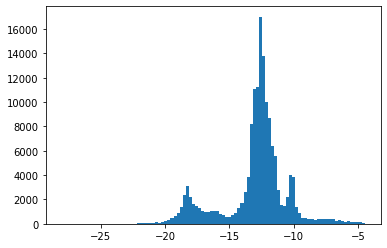

In [31]:
plt.hist(self.link_function(psf_image).numpy().ravel(), bins=100);
# plt.xscale("log")

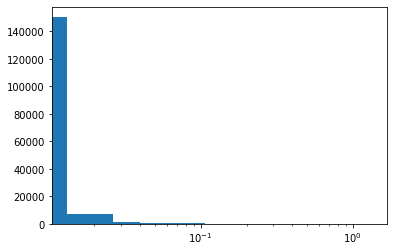

In [11]:
# AE.decoder.trainable_weights
for batch, (X, PSF, PS) in train_dataset:
    plt.hist(X.numpy().ravel(), bins=100)
    plt.xscale("log")
    break